In [1]:
import importlib
import shiftNMF_frozen
importlib.reload(shiftNMF_frozen)
from shiftNMF_frozen import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_WINE, PPM_WINE
import Hardmodel_single_peaks
importlib.reload(Hardmodel_single_peaks)
from Hardmodel_single_peaks import Single_Model
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools

import helpers.fit_functions 
importlib.reload(helpers.fit_functions)
from helpers.fit_functions import *

# shiftNMF

[5.99978451 5.99915313 5.99852176 ... 0.50114961 0.50051823 0.49988686]
3.600563858141756
3.474289087241136


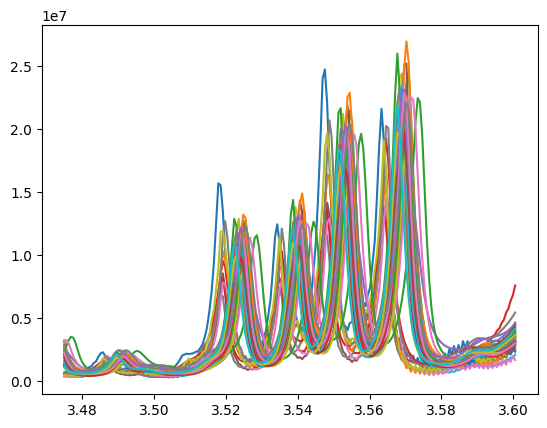

In [2]:
si = 3800
ei = 4000
print(PPM_WINE)
X = X_WINE[:,si:ei]
print(PPM_WINE[si])
print(PPM_WINE[ei])
ppm = PPM_WINE[si:ei]

plt.plot(ppm,X.T)
plt.show()

epoch: 1000, Loss: 0.015336874913144508, Tau: 553.5331968364679


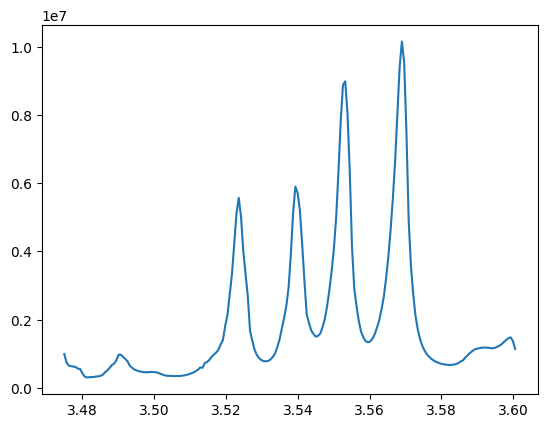

In [3]:

nmf = ShiftNMF(X, 1, lr=0.1, alpha=1e-6, min_imp=0.001)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=1000, tau_iter=0, Lambda=0.000)
plt.plot(ppm,H_est.T)
plt.show()


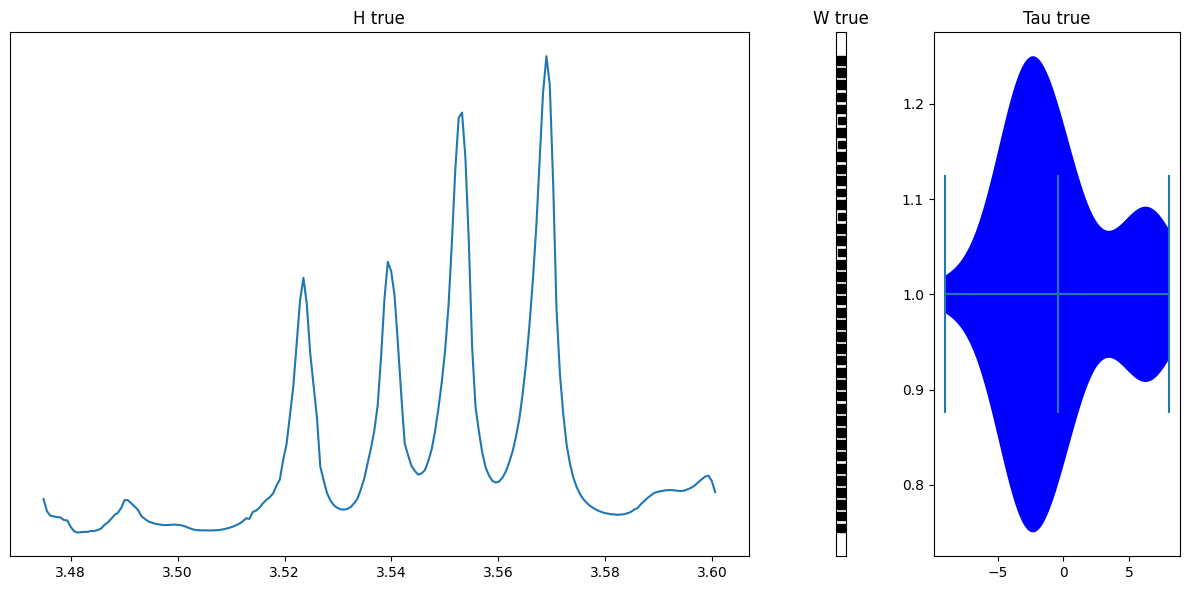

In [4]:
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(12, 6))
N, M = X[:,0:3000].shape
H_scaled = np.zeros_like(H_est)
for i, vec in enumerate(H_est):
    H_scaled[i] = vec/max(vec)

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, ppm, H_scaled.T)
ax1.set_title('H true')

ax2 = plt.subplot(gs[1])
ax2.set_title('W true')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau true')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# Hardmodel

Found peaks:[ 50  75  97 122]
sigma: 3.213696473947986 n:0.2288609821396499
sigma: 3.1785515069663983 n:0.49369885869552776
sigma: 3.063225662281825 n:0.9532344046687106
sigma: 3.378822156751693 n:0.9015791421651842
Lorentzian %:ss: 0.07869395271951403
tensor([0.4777, 0.7363, 0.9991, 0.9938], grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([3.2541, 3.2498, 3.5054, 3.6854], requires_grad=True)


c:\Bachelorprojekt\helpers\fit_functions.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


HERER ARE THE SINGLE FITS SIGMAS
[3.2541265 3.2498221 3.5053575 3.6854122]
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}

initial values:
means:
tensor([ 62.5000,  98.5000,  97.0000,  86.0000,  74.0000,  82.3333,  86.0000,
         89.6667,  98.0000, 109.5000,  75.0000,  73.5000,  86.0000,  50.0000,
        122.0000])
sigmas:
Parameter containing:
tensor([3.2520, 3.4676, 3.5054, 3.3776, 3.3364, 3.3965, 3.4698, 3.4816, 3.4802,
        3.5954, 3.2498, 3.3797, 3.4237, 3.2541, 3.6854], requires_grad=True)
spacing(J-coupling):
Parameter containing:
tensor([25., 47.,  0., 22., 25., 25., 72., 47., 22., 25.,  0., 47., 25.,  0.,
         0.], requires_grad=True)
multiplicity:
tensor([2, 2, 1, 2, 3, 3, 2, 3, 3, 2, 1, 2, 4, 1, 1], dtype=torch.int32)
voigt N:
tensor([ 0.4687,  3.0555,  6.9619,  3.9944,  2.6331,  2.0072,  2.4973,  3.9855,
         4.3576,  6.0230,  1.0269,  3.4362,  3.2459, -0.0894,  

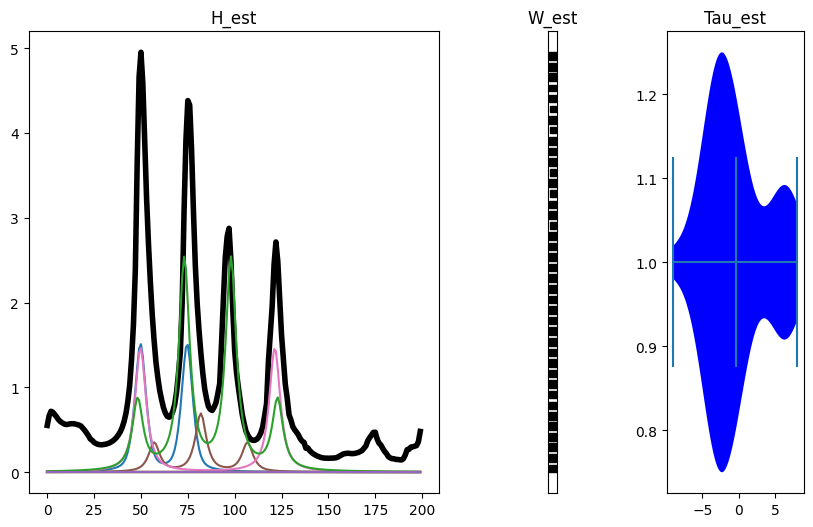

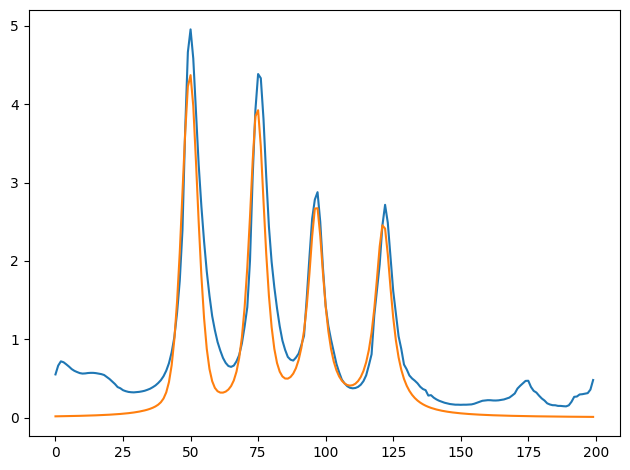

In [5]:

fig = plt.figure(figsize=(10, 6))
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Plot H and H_est
ax1 = plt.subplot(gs[0])
# plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')
x = np.arange(H_est.shape[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# plt.figure(figsize=(15,5))
# plt.plot(H_est.T)
# plt.savefig("shiftcomponents")
# plt.clf()
ymax = 0
for i in range(len(H_est)):
    ymax = max(ymax,(H_est[i]/np.std(H_est[i])).max())
yoffset = ymax
reg_paths = []
lambda_axis = []
C_path = []

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i], min_height=0.5, min_sigma=1, lr=0.1)
    #diff_matrix = calc_difference_matrix(sigmas)
    print("HERER ARE THE SINGLE FITS SIGMAS")
    print(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)

    W, C, running_loss, path, lambdas = hardmodel.fit(verbose=True, return_loss=True, threshold=0.3)
    reg_paths.append(path)
    lambda_axis.append(lambdas)
    C_path.append(C)
    means, sigma, j_coup, mult, n = hardmodel.return_values()
    print("means:")
    print(means)
    print("sigmas:")
    print(sigma)
    print("J coupling:")
    print(j_coup)
    print("multiplicity")
    print(mult)
    print("N")
    print(n)

    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    # plt.figure(figsize=(15,5))
    # plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5, color="k")
    ax1.plot(x,H_est[i]/np.std(H_est[i])+yoffset*i, linewidth=4, color="k")
    for j, vec in enumerate(C):
        ax1.plot(x,vec*W[:,j]+yoffset*i)
# Set tight layout
plt.tight_layout()
plt.show()

[ 1.55416883e+01  2.90135432e+00  2.64951228e+00  2.48586390e+00
  7.97791064e-01  6.72234572e-01  6.45414740e-01  1.90323892e-01
  1.29897890e-01  9.22157460e-02  4.27906550e-02  1.44895788e-02
  1.42305963e-02  9.49400968e-03  3.16811451e-03  2.48663459e-03
 -2.35595866e-03]
0.0


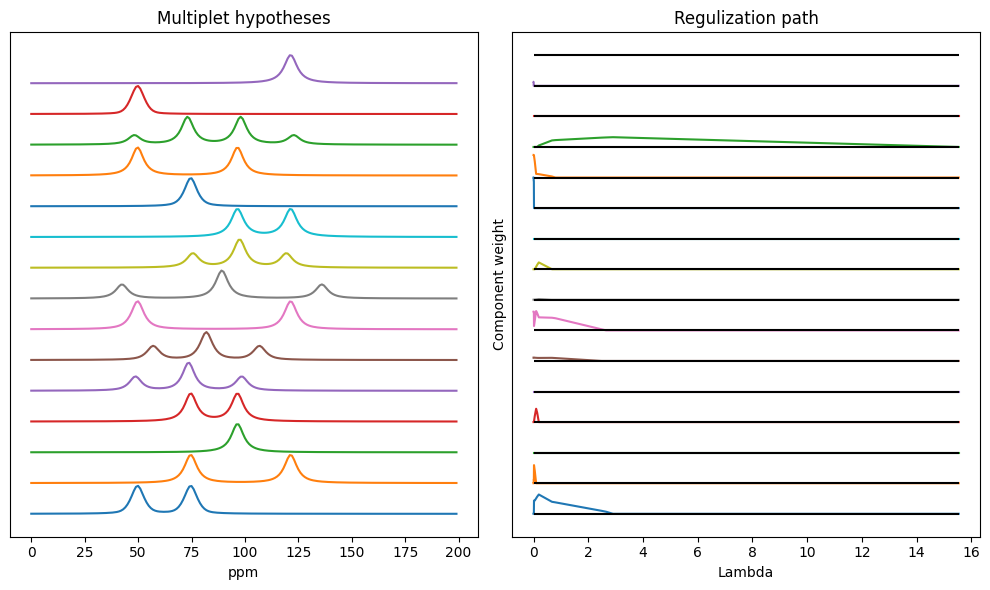

In [9]:

for i in range(len(reg_paths)):
    path = reg_paths[i]
    lambdas = lambda_axis[i]
    print(lambdas[0])
    C = C_path[i]

    plt.plot(C[9])
    plt.show()
    plt.plot(C[9])
    plt.show()

    fig = plt.figure(figsize=(10, 6))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regulization path')
    ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ymax = 1.1
    # for j, vec in enumerate(C):
    #     ymax = max(ymax,(C[j]/max(C[j])).max())

    cutoff = [0]

    yoffset = ymax
    t = 0
    for j, vec in enumerate(C):
        if any(path[0][j] >= cutoff[i]):
            ax1.plot(x,vec/max(vec)+yoffset*t)
            t += 1
    print(path[0].min())
    
    ymax = path[0].max()
    yoffset = ymax
    t = 0
    for j, vec in enumerate(C):
        if any(path[0][j] >= cutoff[i]):
            ax2.plot(lambdas[0],path[0][j]+yoffset*t)
            ax2.hlines(yoffset*t,lambdas[0][-1],lambdas[0][0], color="k")
            t +=1
    ax2.hlines(yoffset*t,lambdas[0][-1],lambdas[0][0], color="k")

    #plt.title("Hardmodelled component regulization path")
    #plt.plot(lambdas[0], reg_paths[i][0].T)
    # plt.savefig("fig"+str(i)+"_path")
    plt.tight_layout()
    plt.show()